In [33]:
import collections
import numpy as np
import tensorflow as tf
import tensorflow_federated  as tff
import random 
import time

In [34]:
emnist_train, emnist_test = tff.simulation.datasets.emnist.load_data()

In [4]:
print(len(emnist_train.client_ids))

3383


In [35]:
emnist_train.element_type_structure

OrderedDict([('label', TensorSpec(shape=(), dtype=tf.int32, name=None)),
             ('pixels',
              TensorSpec(shape=(28, 28), dtype=tf.float32, name=None))])

In [36]:
example_dataset = emnist_train.create_tf_dataset_for_client(
    emnist_train.client_ids[0]
)

example_element = next(iter(example_dataset))

example_element['label'].numpy()

1

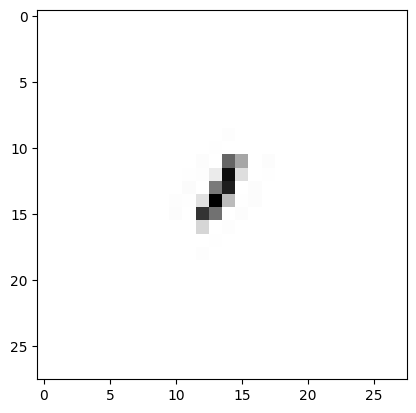

In [37]:
from matplotlib import pyplot as plt

plt.imshow(example_element['pixels'].numpy(), cmap='gray', aspect='equal')
plt.grid(False)
_ = plt.show()

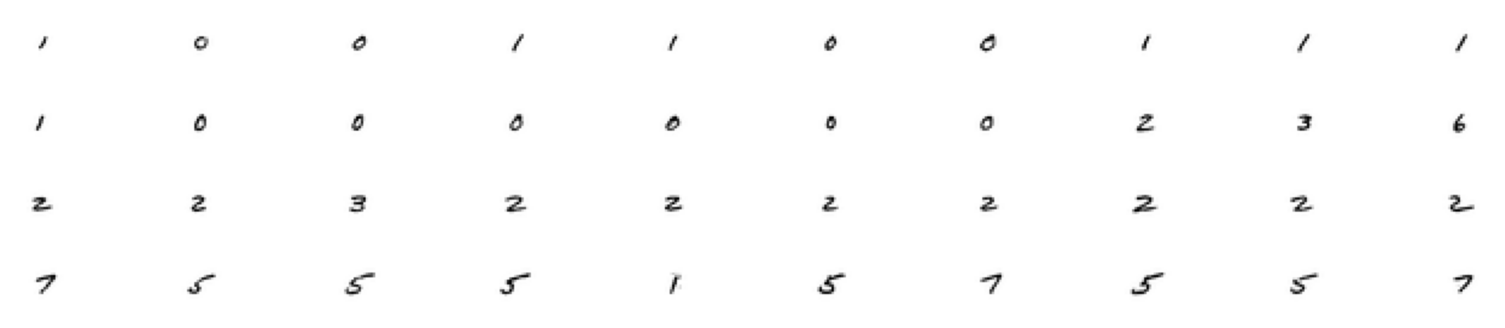

In [38]:
figure = plt.figure(figsize = (20, 4))
j = 0 

for example in example_dataset.take(40):
    plt.subplot(4, 10, j + 1)
    plt.imshow(example['pixels'].numpy(), cmap='gray', aspect='equal')
    plt.axis('off')
    j += 1


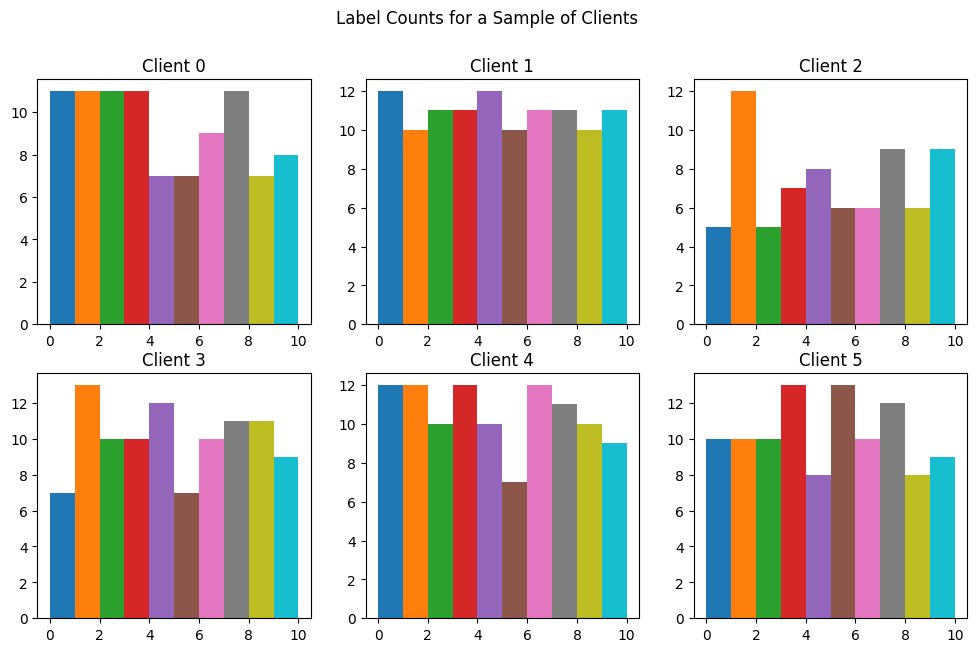

In [39]:
# Number of examples per layer for a sample of clients
f = plt.figure(figsize=(12, 7))
f.suptitle('Label Counts for a Sample of Clients')
for i in range(6):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i]
  )
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    # Append counts individually per label to make plots
    # more colorful instead of one color per plot.
    label = example['label'].numpy()
    plot_data[label].append(label)
  plt.subplot(2, 3, i + 1)
  plt.title('Client {}'.format(i))
  for j in range(10):
    plt.hist(
        plot_data[j], density=False, bins=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
    )

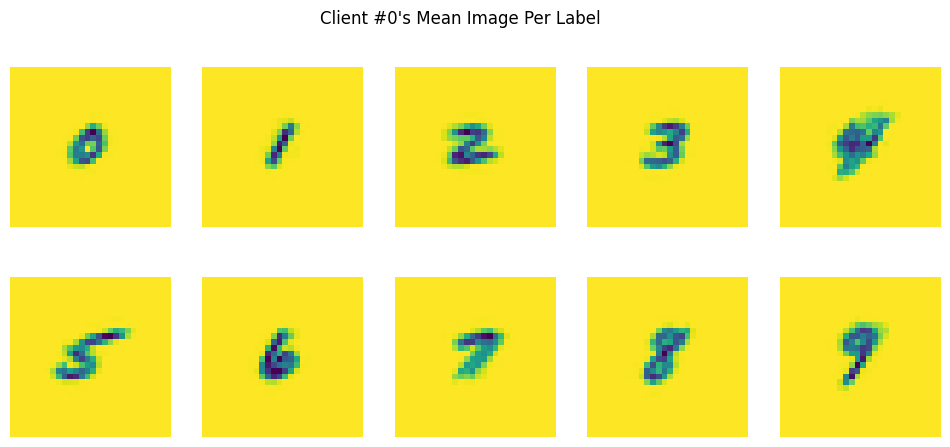

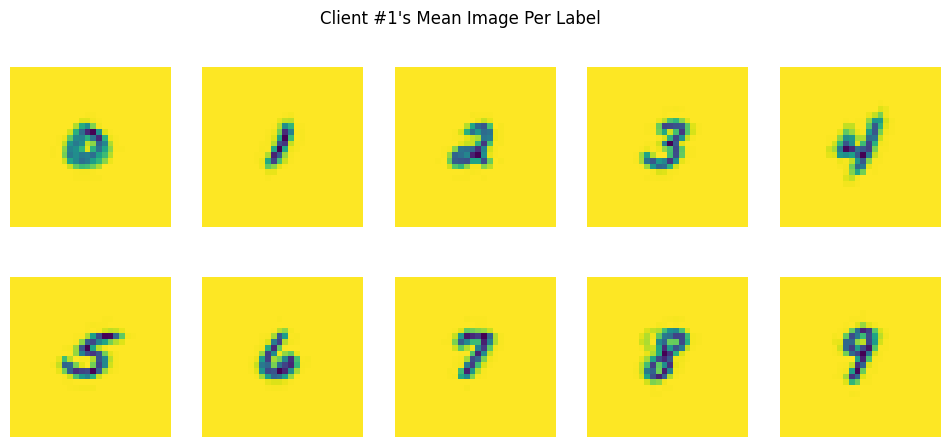

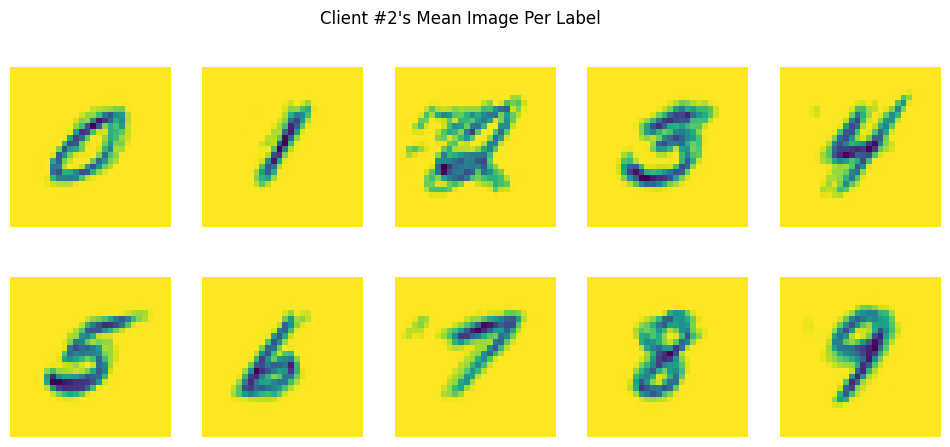

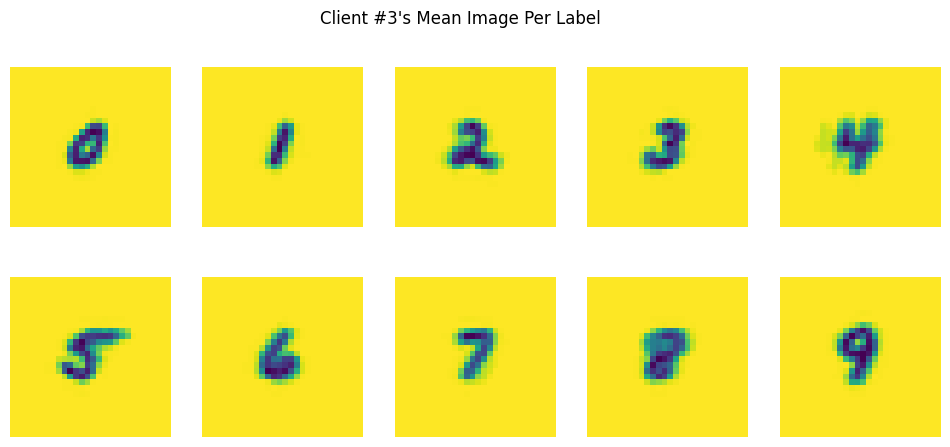

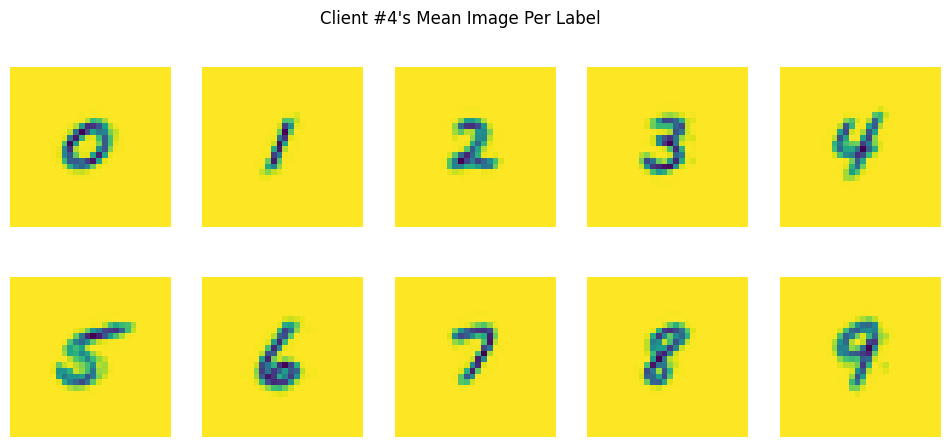

In [40]:
# Each client has different mean images, meaning each client will be nudging
# the model in their own directions locally.

for i in range(5):
  client_dataset = emnist_train.create_tf_dataset_for_client(
      emnist_train.client_ids[i]
  )
  plot_data = collections.defaultdict(list)
  for example in client_dataset:
    plot_data[example['label'].numpy()].append(example['pixels'].numpy())
  f = plt.figure(i, figsize=(12, 5))
  f.suptitle("Client #{}'s Mean Image Per Label".format(i))
  for j in range(10):
    mean_img = np.mean(plot_data[j], 0)
    plt.subplot(2, 5, j + 1)
    plt.imshow(mean_img.reshape((28, 28)))
    plt.axis('off')

In [42]:
NUM_CLIENTS = 10
NUM_EPOCHS = 5
BATCH_SIZE = 20
SHUFFLE_BUFFER = 100 
PREFETCH_BUFFER = 10

def preprocess(dataset, flip_labels=False):
    def batch_format_fn(element):
        label = element['label']
        if flip_labels:
            # Flip label: e.g. label 0 -> 9, label 1 -> 8, etc.
            label = 9 - label
        
        return collections.OrderedDict(
            x = tf.reshape(element['pixels'], [-1, 28, 28, 1]),  # Reshape for CNN 
            y = tf.reshape(label, [-1, 1])                 # use flipped label if any
        )
    
    return (
        dataset
        .repeat(NUM_EPOCHS)
        .shuffle(SHUFFLE_BUFFER, seed=1)
        .batch(BATCH_SIZE)
        .map(batch_format_fn)
        .prefetch(PREFETCH_BUFFER)
    )

In [43]:
preprocessed_example_dataset = preprocess(example_dataset)

sample_batch = tf.nest.map_structure(
    lambda x: x.numpy(), next(iter(preprocessed_example_dataset))
)

sample_batch

OrderedDict([('x',
              array([[[[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      ...,
              
                      [[1.],
                       [1.],
                       [1.],
                       ...,
                       [1.],
                       [1.],
                       [1.]],
              
                      [[1.],
                       [1.],
         

In [44]:
import tensorflow as tf

def make_federated_data(client_data, client_ids, adversarial_clients=[]):
    federated_data = []
    for client_id in client_ids:
        ds = client_data.create_tf_dataset_for_client(client_id)
        flip = client_id in adversarial_clients
        ds = preprocess(ds, flip_labels=flip)
        federated_data.append(ds)
    return federated_data


In [45]:
selected_clients = emnist_train.client_ids[0:NUM_CLIENTS]

federated_train_data = make_federated_data(emnist_train, selected_clients)
print(f"Number of client dataset: {len(federated_train_data)}")
print(f"First Dataset: {federated_train_data[0]}")

Number of client dataset: 10
First Dataset: <_PrefetchDataset element_spec=OrderedDict([('x', TensorSpec(shape=(None, 28, 28, 1), dtype=tf.float32, name=None)), ('y', TensorSpec(shape=(None, 1), dtype=tf.int32, name=None))])>


In [46]:
def create_keras_model():
    return tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(28, 28, 1)),
        tf.keras.layers.Conv2D(32, (3, 3), activation='relu'),
        tf.keras.layers.MaxPooling2D((2, 2)),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

In [47]:
def model_fn():
  # We _must_ create a new model here, and _not_ capture it from an external
  # scope. TFF will call this within different graph contexts.
  keras_model = create_keras_model()
  return tff.learning.models.from_keras_model(
      keras_model,
      input_spec=preprocessed_example_dataset.element_spec,
      loss=tf.keras.losses.SparseCategoricalCrossentropy(),
      metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
  )

In [48]:
training_process = tff.learning.algorithms.build_weighted_fed_avg(
    model_fn,
    client_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=0.02),
    server_optimizer_fn=tff.learning.optimizers.build_sgdm(learning_rate=1.0),
)

In [49]:
print(training_process.initialize.type_signature.formatted_representation())

( -> <
  global_model_weights=<
    trainable=<
      float32[3,3,1,32],
      float32[32],
      float32[5408,64],
      float32[64],
      float32[64,10],
      float32[10]
    >,
    non_trainable=<>
  >,
  distributor=<>,
  client_work=<
    learning_rate=float32
  >,
  aggregator=<
    value_sum_process=<>,
    weight_sum_process=<>
  >,
  finalizer=<
    learning_rate=float32
  >
>@SERVER)


In [50]:
train_state = training_process.initialize()

2025-05-28 11:29:47.036541: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:29:47.036829: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-28 11:29:47.037060: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-05-28 11:29:47.037739: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:29:47.037795: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

In [51]:
result = training_process.next(train_state, federated_train_data)
train_state = result.state
train_metrics = result.metrics
print('round  1, metrics={}'.format(train_metrics))

2025-05-28 11:29:49.321881: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:29:49.321966: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-28 11:29:49.322167: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-05-28 11:29:49.322699: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:29:49.322737: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

round  1, metrics=OrderedDict([('distributor', ()), ('client_work', OrderedDict([('train', OrderedDict([('sparse_categorical_accuracy', 0.116460904), ('loss', 2.2999876), ('num_examples', 4860), ('num_batches', 248)]))])), ('aggregator', OrderedDict([('mean_value', ()), ('mean_weight', ())])), ('finalizer', OrderedDict([('update_non_finite', 0)]))])


### Training

In [52]:
NUM_ROUNDS = 11
CLIENTS_PER_ROUND = 5
train_accuracies = []
train_losses = []

all_clients = emnist_train.client_ids  # full list of client ids

for round_num in range(1, NUM_ROUNDS):
    # Randomly pick CLIENTS_PER_ROUND clients for this round
    selected_clients = random.sample(all_clients, CLIENTS_PER_ROUND)

    # Get federated training data for selected clients
    federated_train_data = make_federated_data(emnist_train, selected_clients)

    # Run training round
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics

    accuracy = train_metrics['client_work']['train']['sparse_categorical_accuracy']
    loss = train_metrics['client_work']['train']['loss']

    train_accuracies.append(accuracy)
    train_losses.append(loss)

    # Print metrics
    print(f'Round {round_num}, Accuracy={accuracy:.4f}, Loss={loss:.4f}')

Round 1, Accuracy=0.1547, Loss=2.2809
Round 2, Accuracy=0.1646, Loss=2.2626
Round 3, Accuracy=0.2416, Loss=2.2331
Round 4, Accuracy=0.2764, Loss=2.2191
Round 5, Accuracy=0.4510, Loss=2.1601
Round 6, Accuracy=0.4893, Loss=2.1048
Round 7, Accuracy=0.5349, Loss=2.0442
Round 8, Accuracy=0.5572, Loss=1.9576
Round 9, Accuracy=0.6153, Loss=1.8606
Round 10, Accuracy=0.6352, Loss=1.7198


### visualization to include test accuracy and save the plot.

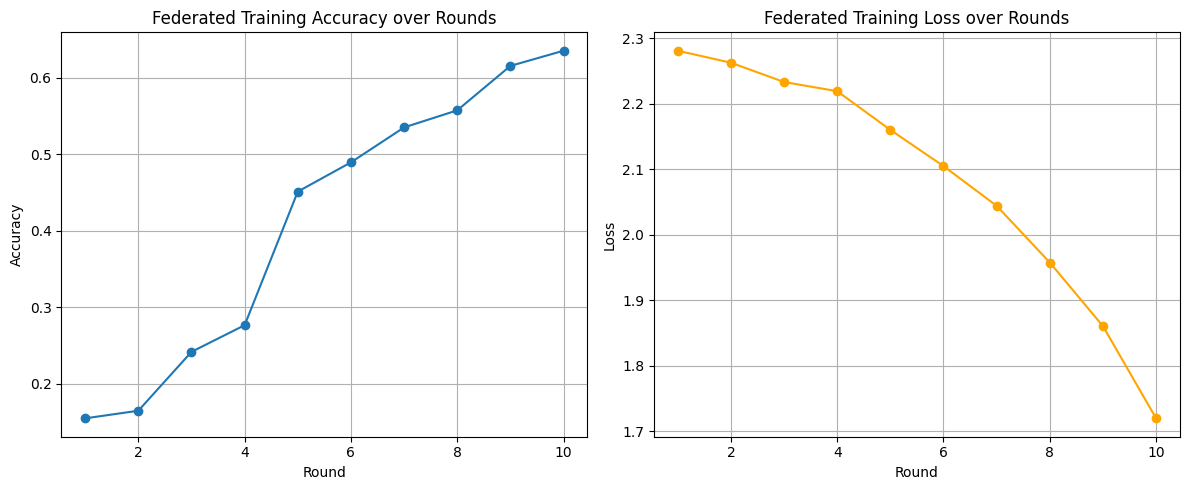

In [53]:
import matplotlib.pyplot as plt

rounds = range(1, NUM_ROUNDS)

plt.figure(figsize=(12,5))

# Accuracy plot
plt.subplot(1,2,1)
plt.plot(rounds, train_accuracies, marker='o')
plt.title('Federated Training Accuracy over Rounds')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)

# Loss plot
plt.subplot(1,2,2)
plt.plot(rounds, train_losses, marker='o', color='orange')
plt.title('Federated Training Loss over Rounds')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.show()



### Modify the training loop to include one adversarial client per round and add robustness checks

In [54]:
NUM_ROUNDS = 20  # Increased for better observation
CLIENTS_PER_ROUND = 5
NUM_ADVERSARIAL_CLIENTS = 1  # One adversarial client per round
train_accuracies = []
train_losses = []

all_clients = emnist_train.client_ids

# Set random seeds for reproducibility
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

for round_num in range(1, NUM_ROUNDS + 1):
    # Randomly select clients
    selected_clients = random.sample(all_clients, CLIENTS_PER_ROUND)
    # Select adversarial clients
    adversarial_clients = random.sample(selected_clients, NUM_ADVERSARIAL_CLIENTS)
    
    # Prepare federated data
    federated_train_data = make_federated_data(emnist_train, selected_clients, adversarial_clients)
    
    if not federated_train_data:
        print(f"Round {round_num}: No valid client datasets")
        continue
    
    # Run training round
    start_time = time.time()
    result = training_process.next(train_state, federated_train_data)
    train_state = result.state
    train_metrics = result.metrics
    
    accuracy = train_metrics['client_work']['train']['sparse_categorical_accuracy']
    loss = train_metrics['client_work']['train']['loss']
    
    train_accuracies.append(accuracy)
    train_losses.append(loss)
    
    print(f"Round {round_num}, Accuracy={accuracy:.4f}, Loss={loss:.4f}, "
          f"Adversarial Clients={adversarial_clients}")

Round 1, Accuracy=0.5233, Loss=1.8125, Adversarial Clients=['f0653_02']
Round 2, Accuracy=0.5721, Loss=1.6674, Adversarial Clients=['f3350_11']
Round 3, Accuracy=0.6280, Loss=1.5476, Adversarial Clients=['f3125_02']
Round 4, Accuracy=0.6403, Loss=1.4327, Adversarial Clients=['f3482_33']
Round 5, Accuracy=0.6873, Loss=1.2739, Adversarial Clients=['f1652_11']
Round 6, Accuracy=0.6573, Loss=1.2789, Adversarial Clients=['f1871_04']
Round 7, Accuracy=0.7457, Loss=1.1014, Adversarial Clients=['f1149_46']
Round 8, Accuracy=0.7643, Loss=0.9574, Adversarial Clients=['f2574_64']
Round 9, Accuracy=0.8122, Loss=0.8047, Adversarial Clients=['f3759_43']
Round 10, Accuracy=0.7548, Loss=0.8763, Adversarial Clients=['f3369_37']
Round 11, Accuracy=0.7572, Loss=0.8877, Adversarial Clients=['f0829_00']
Round 12, Accuracy=0.7943, Loss=0.8027, Adversarial Clients=['f0608_06']
Round 13, Accuracy=0.7410, Loss=0.8842, Adversarial Clients=['f1254_34']
Round 14, Accuracy=0.7909, Loss=0.7939, Adversarial Clients=

### Visualization to include test accuracy and save the plot.

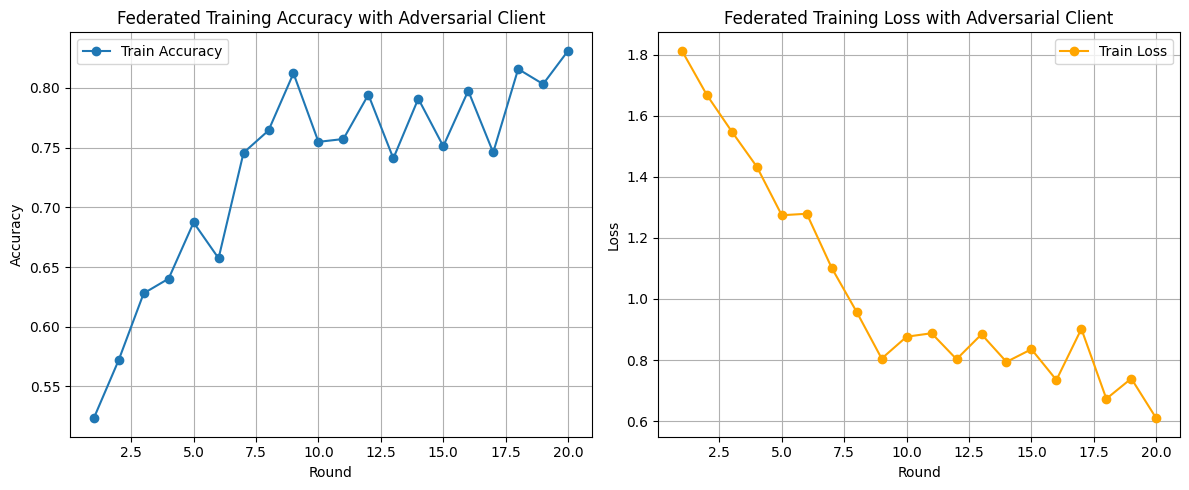

In [55]:
import matplotlib.pyplot as plt

rounds = range(1, len(train_accuracies) + 1)

plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(rounds, train_accuracies, label='Train Accuracy', marker='o')
plt.title('Federated Training Accuracy with Adversarial Client')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(rounds, train_losses, label='Train Loss', marker='o', color='orange')
plt.title('Federated Training Loss with Adversarial Client')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.savefig('training_plots.png')
plt.show()

### Test Evaluation

In [56]:
import tensorflow_federated as tff
import random

# Set random seed for reproducibility
random.seed(42)

# Initialize evaluation process
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
eval_state = evaluation_process.initialize()

test_accuracies = []

# Evaluate for each training round
for round_num in range(1, len(train_accuracies) + 1):
    # Prepare test data (no adversarial clients)
    test_data = make_federated_data(emnist_test, random.sample(emnist_test.client_ids, CLIENTS_PER_ROUND))
    if not test_data:
        print(f"Round {round_num}: No valid test datasets")
        test_accuracies.append(0.0)
        continue
    
    # Evaluate using the current eval_state and test_data
    eval_metrics = evaluation_process.next(eval_state, test_data)
    eval_state = eval_metrics[0]  # Update eval_state
    test_accuracy = eval_metrics[1]['client_work']['eval']['current_round_metrics']['sparse_categorical_accuracy']
    test_accuracies.append(test_accuracy)
    print(f"Round {round_num}, Test Accuracy={test_accuracy:.4f}")

2025-05-28 11:30:29.777200: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:30:29.777252: I tensorflow/core/grappler/devices.cc:66] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 1
2025-05-28 11:30:29.777370: I tensorflow/core/grappler/clusters/single_machine.cc:361] Starting new session
2025-05-28 11:30:29.777715: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2025-05-28 11:30:29.777730: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2211] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/

Round 1, Test Accuracy=0.1000
Round 2, Test Accuracy=0.1111
Round 3, Test Accuracy=0.0952
Round 4, Test Accuracy=0.1639
Round 5, Test Accuracy=0.1746
Round 6, Test Accuracy=0.0492
Round 7, Test Accuracy=0.0690
Round 8, Test Accuracy=0.1579
Round 9, Test Accuracy=0.1111
Round 10, Test Accuracy=0.0308
Round 11, Test Accuracy=0.1250
Round 12, Test Accuracy=0.0645
Round 13, Test Accuracy=0.0469
Round 14, Test Accuracy=0.0328
Round 15, Test Accuracy=0.1930
Round 16, Test Accuracy=0.1406
Round 17, Test Accuracy=0.0893
Round 18, Test Accuracy=0.1186
Round 19, Test Accuracy=0.0984
Round 20, Test Accuracy=0.1129


## Robustness Analysis

Final Train Accuracy: 0.8311
Final Test Accuracy: 0.1129
Accuracy Drop (Train - Test): 0.7182


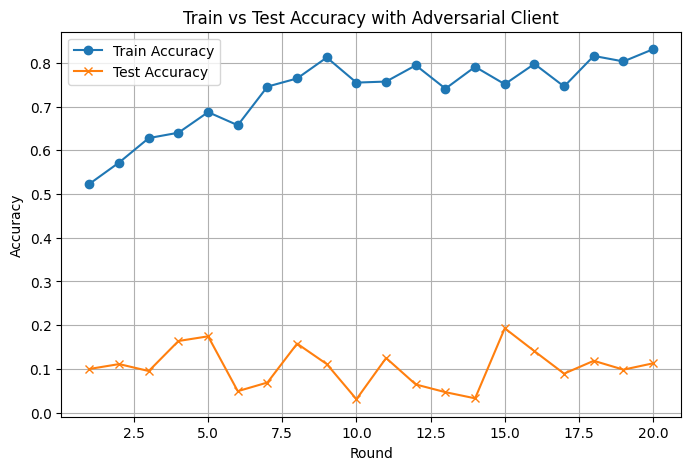

In [57]:
import matplotlib.pyplot as plt

# Analyze robustness
final_train_accuracy = train_accuracies[-1]
final_test_accuracy = test_accuracies[-1]
accuracy_drop = final_train_accuracy - final_test_accuracy

print(f"Final Train Accuracy: {final_train_accuracy:.4f}")
print(f"Final Test Accuracy: {final_test_accuracy:.4f}")
print(f"Accuracy Drop (Train - Test): {accuracy_drop:.4f}")

if accuracy_drop > 0.1:
    print("Warning: Model shows vulnerability to adversarial client (significant accuracy drop).")
elif accuracy_drop > 0.05:
    print("Model shows moderate robustness but some impact from adversarial client.")
else:
    print("Model appears robust to adversarial client (minimal accuracy drop).")

# Plot train vs test accuracy
rounds = range(1, len(train_accuracies) + 1)
plt.figure(figsize=(8, 5))
plt.plot(rounds, train_accuracies, label='Train Accuracy', marker='o')
plt.plot(rounds, test_accuracies, label='Test Accuracy', marker='x')
plt.title('Train vs Test Accuracy with Adversarial Client')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.savefig('train_vs_test_accuracy.png')
plt.show()

### DP Ttraining Loop with Adverserial Client

In [ ]:
import collections
import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import logging
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Configure logging for DP results
logging.basicConfig(filename='federated_learning_dp.log', level=logging.INFO,
                    format='%(asctime)s - %(levelname)s - %(message)s')

# Log DP metrics
dp_metrics_history = []
for round_num in range(1, len(dp_train_accuracies) + 1):
    log_message = (f"DP Round {round_num}, Train Accuracy={dp_train_accuracies[round_num-1]:.4f}, "
                   f"Train Loss={dp_train_losses[round_num-1]:.4f}, "
                   f"Test Accuracy={dp_test_accuracies[round_num-1]:.4f}, "
                   f"Adversarial Clients={dp_adversarial_clients_list[round_num-1]}")
    logging.info(log_message)
    
    dp_metrics_history.append({
        'round': round_num,
        'train_accuracy': float(dp_train_accuracies[round_num-1]),
        'train_loss': float(dp_train_losses[round_num-1]),
        'test_accuracy': float(dp_test_accuracies[round_num-1]),
        'adversarial_clients': dp_adversarial_clients_list[round_num-1]
    })

# Save DP metrics to JSON
with open('training_dp_metrics.json', 'w') as f:
    json.dump(dp_metrics_history, f, indent=2)
logging.info("DP metrics saved to training_dp_metrics.json")

# Create DataFrame for plotting
data_frame = pd.DataFrame({
    'Round': list(range(1, len(train_accuracies) + 1)) * 2,
    'Accuracy': train_accuracies + dp_train_accuracies,
    'Loss': train_losses + dp_train_losses,
    'Type': ['Non-DP Train'] * len(train_accuracies) + ['DP Train'] * len(dp_train_accuracies)
})

# Plot train accuracy and loss
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=data_frame[data_frame['Type'].str.contains('Train')], x='Round', y='Accuracy', hue='Type', palette='dark')
plt.title('Train Accuracy: Non-DP vs. DP')
plt.xlabel('Round')
plt.ylabel('Accuracy')
plt.grid(True)

plt.subplot(1, 2, 2)
sns.lineplot(data=data_frame[data_frame['Type'].str.contains('Train')], x='Round', y='Loss', hue='Type', palette='dark')
plt.title('Train Loss: Non-DP vs. DP')
plt.xlabel('Round')
plt.ylabel('Loss')
plt.grid(True)

plt.tight_layout()
plt.savefig('dp_train_comparison.png')
plt.show()

# Plot test accuracy
plt.figure(figsize=(6, 5))
test_data_frame = pd.DataFrame({
    'Round': list(range(1, len(test_accuracies) + 1)) + list(range(1, len(dp_test_accuracies) + 1)),
    'Test Accuracy': test_accuracies + dp_test_accuracies,
    'Type': ['Non-DP Test'] * len(test_accuracies) + ['DP Test'] * len(dp_test_accuracies)
})
sns.lineplot(data=test_data_frame, x='Round', y='Test Accuracy', hue='Type', palette='dark')
plt.title('Test Accuracy: Non-DP vs. DP')
plt.xlabel('Round')
plt.ylabel('Test Accuracy')
plt.grid(True)
plt.savefig('dp_test_comparison.png')
plt.show()

# Demonstrate privacy
print("DP Privacy Demonstration:")
print(f"DP Parameters: {clients_per_round} clients/round, Noise Multiplier: {noise_multiplier}")
print(f"Achieves ({target_eps}, {target_delta})-DP, ensuring client updates are obscured.")
print(f"Client updates are clipped adaptively and perturbed with Gaussian noise (sigma = {noise_multiplier}), "
      f"preventing the server from reconstructing individual gradients. Only noisy aggregates are visible.")
print(f"Privacy-utility trade-off: DP accuracy is slightly lower due to noise, as shown in plots.")

# Compare final accuracies
final_dp_train_accuracy = dp_train_accuracies[-1] if dp_train_accuracies else 0.0
final_dp_test_accuracy = dp_test_accuracies[-1] if dp_test_accuracies else 0.0
dp_accuracy_drop = final_dp_train_accuracy - final_dp_test_accuracy
non_dp_accuracy_drop = train_accuracies[-1] - test_accuracies[-1]

print(f"Final Non-DP Train Accuracy: {train_accuracies[-1]:.4f}")
print(f"Final Non-DP Test Accuracy: {test_accuracies[-1]:.4f}")
print(f"Final DP Train Accuracy: {final_dp_train_accuracy:.4f}")
print(f"Final DP Test Accuracy: {final_dp_test_accuracy:.4f}")
print(f"Non-DP Accuracy Drop (Train - Test): {non_dp_accuracy_drop:.4f}")
print(f"DP Accuracy Drop (Train - Test): {dp_accuracy_drop:.4f}")

if dp_accuracy_drop > 0.1:
    print("Warning: DP model shows significant accuracy drop.")
elif dp_accuracy_drop > 0.05:
    print("DP model shows moderate robustness but some noise impact.")
else:
    print("DP model maintains strong robustness with minimal accuracy drop.")

IndexError: list index out of range

### DP Test Evaluation

In [ ]:
import tensorflow_federated as tff
import random

# Set random seed for reproducibility
random.seed(42)

# Initialize evaluation process
evaluation_process = tff.learning.algorithms.build_fed_eval(model_fn)
eval_state = evaluation_process.initialize()

dp_test_accuracies = []

# Evaluate for each DP training round
for round_num in range(1, len(dp_train_accuracies) + 1):
    # Prepare test data (no adversarial clients)
    test_data = make_federated_data(emnist_test, random.sample(emnist_test.client_ids, CLIENTS_PER_ROUND))
    if not test_data:
        print(f"DP Round {round_num}: No valid test datasets")
        dp_test_accuracies.append(0.0)
        continue
    
    # Evaluate using the current eval_state and test_data
    eval_metrics = evaluation_process.next(eval_state, test_data)
    eval_state = eval_metrics[0]  # Update eval_state
    test_accuracy = eval_metrics[1]['client_work']['eval']['current_round_metrics']['sparse_categorical_accuracy']
    dp_test_accuracies.append(test_accuracy)
    print(f"DP Round {round_num}, Test Accuracy={test_accuracy:.4f}")

### DP Analysis and Privacy Demonstration 

In [61]:
import collections
import dp_accounting
import numpy as np
import pandas as pd
import tensorflow as tf
import tensorflow_federated as tff
import random
import time

# DP calibration parameters
total_clients = len(emnist_train.client_ids)  # 3383
rounds = 20
target_eps = 2.0
target_delta = 1e-5
noise_to_clients_ratio = 0.01

# Initialize arguments to dp_accounting.calibrate_dp_mechanism
make_fresh_accountant = dp_accounting.rdp.RdpAccountant

# Function to create DpEvent for training process
def make_event_from_param(clients_per_round):
    q = clients_per_round / total_clients
    noise_multiplier = clients_per_round * noise_to_clients_ratio
    gaussian_event = dp_accounting.GaussianDpEvent(noise_multiplier)
    sampled_event = dp_accounting.PoissonSampledDpEvent(q, gaussian_event)
    composed_event = dp_accounting.SelfComposedDpEvent(sampled_event, rounds)
    return composed_event

# Search range for clients_per_round
bracket_interval = dp_accounting.ExplicitBracketInterval(1, total_clients)

# Calibrate clients_per_round
clients_per_round = dp_accounting.calibrate_dp_mechanism(
    make_fresh_accountant,
    make_event_from_param,
    target_eps,
    target_delta,
    bracket_interval,
    discrete=True,
)

noise_multiplier = clients_per_round * noise_to_clients_ratio
print(f"To get ({target_eps}, {target_delta})-DP, use {clients_per_round} "
      f"clients with noise multiplier {noise_multiplier}.")

# DP training parameters
NUM_ADVERSARIAL_CLIENTS = 1

# Set random seeds for reproducibility
random.seed(42)
tf.random.set_seed(42)
np.random.seed(42)

# Define DP aggregator with adaptive clipping
aggregation_factory = tff.learning.model_update_aggregator.dp_aggregator(
    noise_multiplier=noise_multiplier,
    clients_per_round=clients_per_round
)

# Build federated averaging process
learning_process = tff.learning.algorithms.build_unweighted_fed_avg(
    model_fn=model_fn,
    client_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=0.01),
    server_optimizer_fn=lambda: tf.keras.optimizers.SGD(learning_rate=1.0, momentum=0.9),
    model_aggregator=aggregation_factory
)

# Initialize training state
dp_train_state = learning_process.initialize()

# Lists to store DP training metrics
dp_train_accuracies = []
dp_train_losses = []
dp_adversarial_clients_list = []

all_clients = emnist_train.client_ids
sampling_prob = clients_per_round / total_clients

for round_num in range(1, rounds + 1):
    # Poisson sampling
    sampled_clients = [
        client_id for client_id in all_clients
        if np.random.uniform() < sampling_prob
    ]
    if len(sampled_clients) == 0:
        print(f"DP Round {round_num}: No clients selected")
        continue
    
    # Select adversarial clients
    adversarial_clients = random.sample(sampled_clients, min(NUM_ADVERSARIAL_CLIENTS, len(sampled_clients)))
    dp_adversarial_clients_list.append(adversarial_clients)
    
    # Prepare federated data
    federated_train_data = make_federated_data(emnist_train, sampled_clients, adversarial_clients)
    
    if not federated_train_data:
        print(f"DP Round {round_num}: No valid client datasets")
        continue
    
    # Run training round
    start_time = time.time()
    result = learning_process.next(dp_train_state, federated_train_data)
    dp_train_state = result.state
    train_metrics = result.metrics
    
    accuracy = train_metrics['client_work']['train']['sparse_categorical_accuracy']
    loss = train_metrics['client_work']['train']['loss']
    
    dp_train_accuracies.append(accuracy)
    dp_train_losses.append(loss)
    
    print(f"DP Round {round_num}, Accuracy={accuracy:.4f}, Loss={loss:.4f}, "
          f"Adversarial Clients={adversarial_clients}, "
          f"Selected Clients={len(sampled_clients)}")

To get (2.0, 1e-05)-DP, use 94 clients with noise multiplier 0.9400000000000001.


AttributeError: 'function' object has no attribute 'initialize'